# **Tema IC 2023**

## Task 1 - AES ADD (30p)


În laboratorul 6 am observat o vulnerabilitate AES atunci când este folosit în modului ECB. Am decis să modificăm algoritmul astfel încât să putem evita blocurile criptate duplicate rezultate în urma criptării blocurile identice din plaintext. Aveți la dispoziție codul versiunii AES-ADD, folosit pentru a cripta imagini în formatul [PPM P6](https://en.wikipedia.org/wiki/Netpbm).

In [131]:
# %pip install pycryptodome

In [132]:
import math
import os

from Crypto.Cipher import AES

BLOCK_SIZE = 16
UMAX = int(math.pow(256, BLOCK_SIZE))


def num_to_bytes(n: int) -> bytes:
    length = (n.bit_length() + 7) // 8
    padding = length % BLOCK_SIZE
    if padding != 0:
        length += BLOCK_SIZE - padding
    return n.to_bytes(length, "big")


def bytes_to_num(b: bytes) -> int:
    return int(b.hex(), 16)


def parse_header_ppm(data: bytes) -> tuple[bytes, bytes]:
    header_len = 0
    header_lines = 0
    inside_comment = False

    for header_len, b in enumerate(data):
        if inside_comment and b == ord("\n"):
            inside_comment = False
            continue
        if b == ord("#"):
            inside_comment = True
            continue
        if b == ord("\n"):
            # counts only non-comment lines
            header_lines += 1
        if header_lines == 3:
            # include the current '\n' character in the header
            header_len += 1
            break

    return data[:header_len], data[header_len:]


def pad(plaintext: bytes) -> bytes:
    padding = BLOCK_SIZE - len(plaintext) % BLOCK_SIZE
    return plaintext + bytes(chr(padding), encoding="utf8") * padding


def aes_add_encrypt(plaintext: bytes, key: bytes) -> bytes:
    cipher = AES.new(key, AES.MODE_ECB)
    ciphertext = cipher.encrypt(pad(plaintext))
    blocks = [
        ciphertext[i * BLOCK_SIZE : (i + 1) * BLOCK_SIZE]
        for i in range(len(ciphertext) // BLOCK_SIZE)
    ]

    iv = os.urandom(BLOCK_SIZE)
    blocks.insert(0, iv)

    for i in range(len(blocks) - 1):
        prev_block = bytes_to_num(blocks[i])
        curr_block = bytes_to_num(blocks[i + 1])

        n_curr_block = (prev_block + curr_block) % UMAX
        blocks[i + 1] = num_to_bytes(n_curr_block)

    ciphertext_add = b"".join(blocks)

    return ciphertext_add


def aes_add_encrypt_file(
    input_filename: str,
    output_filename: str,
    key: bytes,
) -> None:
    with open(input_filename, "rb") as f:
        header, data = parse_header_ppm(f.read())

    c_text = aes_add_encrypt(data, key)

    with open(output_filename, "wb") as fw:
        fw.write(header)
        fw.write(c_text)


# Imaginea poate fi criptată folosind codul de mai jos.
#
# KEY = b"ttxgWJEjvRReRIyrlKJaFtocIvDyQqni"
# INPUT = "my_precious.ppm"
# OUTPUT = "my_precious.enc.ppm"

# aes_add_encrypt_file(input_filename=INPUT, output_filename=OUTPUT, key=KEY)

Algorimtul de criptare folosește în continuare varianta AES-ECB, dar adaugă o operație nouă asupra blocurilor ciphertext. În această variantă, algoritmul urmează ideea *cipher block chaining* (figura de mai jos prezinta modul CBC).

![CBC](https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/CBC_encryption.svg/1200px-CBC_encryption.svg.png)

În varianta AES-ADD fiecare block este modificat prin adunarea cu block-ul anterior, așa cum se observă în funcția de criptare. Figura de mai sus poate fi adaptată codului nostru astfel:

```
       [plain 1]             [plain 2]             [plain 3]       ...
           |                     |                     |
           | (AES ECB)           | (AES ECB)           | (AES ECB)
           V                     V                     V
       [ ECB 1 ]             [ ECB 1 ]             [ ECB 3 ]
+iv -> [ enc 1 ]   --- + --> [ enc 2 ]   --- + --> [ enc 3 ]   --- ...
```

Sperăm că prin această modificare să evităm problema blocurilor duplicate.

Task-ul vostru este să descoperiți FLAG-ul ascuns într-o imagine criptată cu acest algoritm. Urmărind schema de mai sus, ar trebui să fie destul de simplu, mai ales în cazul în care imaginea criptată are și un background. Pentru a vizualiza mai bine, aveți și următorul exemplu:

![AES](https://i.stack.imgur.com/bXAUL.png)



Completați codul de mai jos pentru a efectua atacul. Acesta va citi imaginea criptată pe care o avem la dispoziție și va recrea imaginea obținută de voi.

Chiar dacă nu vom obține imaginea originală, FLAG-ul ar trebui să fie destul de vizibil.

Pentru testare/debugging, puteți cripta și alte imagini în formatul PPM folosind funcția `aes_add_encrypt_file()`. Imaginile trebuie să conțină doar alb și negru pentru rezultatele cele mai bune.

In [133]:
# ![ -f my_precious.enc.ppm ] && echo "File already exists." || wget https://github.com/ACS-IC-labs/IC-labs/raw/main/teme/tema23/my_precious.enc.ppm

'[' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


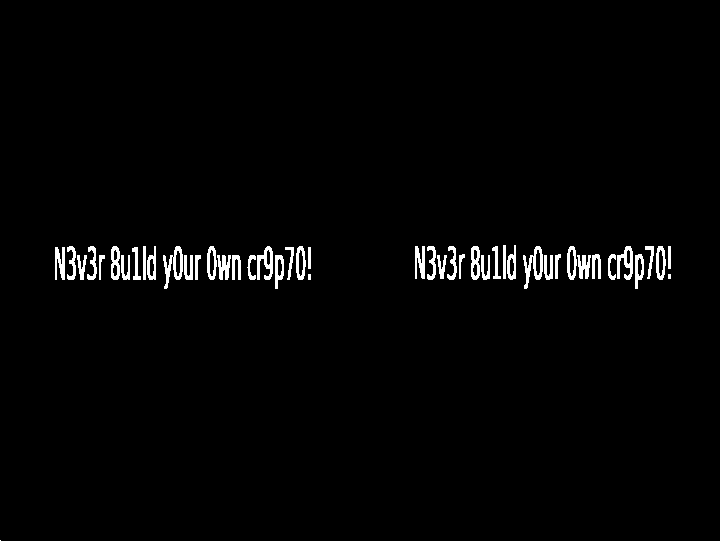

In [134]:
from collections import Counter, defaultdict

from PIL import Image


def get_image_size(header: bytes) -> tuple[int, int]:
    dheader: str = header.decode("utf-8")

    # ignore comments as well
    lines = [line for line in dheader.split("\n") if not line.startswith("#")]

    # PPM format:
    #   - line 1 -> P6
    #   - line 2 -> width height
    #   - line 3 -> maximum pixel intensity
    width, height = map(int, lines[1].split())

    return width, height


def break_encryption(
    ecb_blocks: list[int], w: int, h: int, background: int
) -> Image.Image:
    im = Image.new("RGB", (w, h))
    data = []
    for b in ecb_blocks:
        if b == background:
            data += [(0, 0, 0)]
        else:
            data += [(255, 255, 255)]
    im.putdata(data)
    return im


def decrypt_image(enc_filename: str) -> Image.Image:
    with open(enc_filename, "rb") as file:
        header, data = parse_header_ppm(file.read())

    width, height = get_image_size(header)

    ########## SOLUȚIA AICI ##########
    # TODO 1: Inversați pasul ADD din AES-ADD.
    ecb_blocks = [
        data[i * BLOCK_SIZE : (i + 1) * BLOCK_SIZE]
        for i in range(len(data) // BLOCK_SIZE)
    ]

    for i in range(len(ecb_blocks) - 1)[::-1]:
        prev_block = bytes_to_num(ecb_blocks[i])
        curr_block = bytes_to_num(ecb_blocks[i + 1])

        n_curr_block = (curr_block - prev_block) % UMAX
        ecb_blocks[i + 1] = num_to_bytes(n_curr_block)
    # skip IV
    ecb_blocks=ecb_blocks[1:]


    # TODO 2: Determinati block-ul din cipertext-ul AES-ECB care se repetă de
    # cele mai multe ori. Acesta va fi culoarea de background, in imaginea
    # alb-negru pe care o veti obtine.

    block_count=Counter()
    for block in ecb_blocks:
        block_count[block]+=1

    background = block_count.most_common(1)[0][0]
    ##################################

    # Using the scale factor, we make the image more readable. Also, the image
    # will repeat `scale_factor` times.
    scale_factor = 2
    img = break_encryption(
        ecb_blocks,
        round(scale_factor * 3 * width / 16),
        height // scale_factor + 1,
        background,
    )
    return img


im = decrypt_image("my_precious.enc.ppm")
im

## Task 2 - Differential Cryptanalysis (70p)

Avem următorul program de gestionare a notițelor. Programul ne permite să scriem notițe și să citim notițele scrise. Desigur, mesajele salvate vor trebui criptate, pentru a ne asigura că nu pot fi citite de altcineva.

Algoritmul este unul relativ simplu, bazat pe cifrul bloc [Nimbus](https://en.wikipedia.org/wiki/Nimbus_(cipher)). Cu o cheie de 128 bits și blocuri de 64 bits, algoritmul criptează mesajul în 5 runde, așa cum se poate observa în funcția `encrypt_block()`. Rundele pot fi descrise prin $Y_i = K_i^{odd} \cdot g(Y_{i-1} \oplus K_i)$, unde $K_i$ și $K_i^{odd}$ sunt subcheile rundei, iar  $K_i^{odd}$ este o subcheie forțată să fie impară.
De asemenea, funcția $g(\cdot)$ inversează biții unui bloc, ceea ce oferă algoritmului și o proprietate de *neliniaritate*.

*Asigurați-vă că ați înțeles funcția `encrypt_block()` înainte de a implementa la atacul.*

In [135]:
import binascii

ROUNDS = 5
BLOCK_LEN = 8
HEX_BLOCK_LEN = BLOCK_LEN * 2
MAX_NOTES = 2048
MAX_NOTE_LEN = 512


def mod_64(val: int) -> int:
    """Calculează val modulo 2**64"""
    return val & ((1 << 64) - 1)


def pad(plaintext: bytes) -> bytes:
    if len(plaintext) % BLOCK_LEN != 0:
        return plaintext + b"\0" * (BLOCK_LEN - (len(plaintext) % BLOCK_LEN))
    return plaintext


def g(x: int) -> int:
    b = format(x, "b").rjust(BLOCK_LEN * 8, "0")
    return int(b[::-1], 2)


def encrypt_block(plaintext: bytes) -> str:
    """Encrypts a given block of plaintext"""
    k = b"ttxgWJEjvRReRIyrlKJaFtocIvDyQqnicIKRFaaa"

    assert len(plaintext) * ROUNDS == len(k)

    result = int.from_bytes(plaintext, byteorder="big")
    for i in range(ROUNDS):
        # Fiecare pas al for-ului reprezintă o rundă de criptare
        # Obținem un block din cheia principală pentru a-l folosi ca subcheie
        key = int.from_bytes(
            k[i * BLOCK_LEN : (i + 1) * BLOCK_LEN],
            byteorder="big",
        )

        # Ne asigurăm ca vom avea o cheie de valoare impară
        key_odd = key | 1

        # XOR-am blocul curent cu cheia
        result ^= key

        # Efectuăm un inversarea biților
        result = g(result)

        # Efectuăm înmulțirea cu cheia impară și ne asigurăm că rămânem cu un
        # block de dimensiune 64 biti
        result = mod_64(result * key_odd)

    # Transformăm rezultatul în format hex
    return format(result, "x").rjust(HEX_BLOCK_LEN, "0")


def encrypt(msg: bytes) -> str:
    plain = pad(msg)
    result = ""
    for i in range(0, len(plain), BLOCK_LEN):
        result += encrypt_block(plain[i : i + BLOCK_LEN])
    return result


def menu(notes: list[str]) -> list[str] | None:
    print(
        """
1) Store
2) Retrieve
Anything else to quit
"""
    )
    ui = input("Selection? ").rstrip()
    if ui == "1":
        if len(notes) >= MAX_NOTES:
            print("Max capacity")
            return notes
        ui = input("Give me a note to encrypt: ").rstrip()
        try:
            msg = binascii.unhexlify(ui)
        except:
            print("Invalid input.")
            return notes
        if len(msg) > MAX_NOTE_LEN:
            print("Invalid input.")
        else:
            notes.append(encrypt(msg))
    elif ui == "2":
        ui = input("What index would you like to read? ").rstrip()
        try:
            index = int(ui)
        except:
            print("Invalid index.")
            return notes
        if index >= 0 and index < len(notes):
            print(notes[index])
        else:
            print("Invalid index.")
    else:
        return None
    return notes


# Exemplu de rulare meniu interactiv:
#
# notes = []
# while notes is not None:
# 	notes = menu(notes)

Atacul pe care ne dorim să îl implementăm este descris în [Differential Cryptanalysis of Nimbus](https://link.springer.com/content/pdf/10.1007/3-540-45473-X_16.pdf), pentru a experimenta cu conceptul de Differential Cryptanalysis pe un algoritm de criptare mai simplu decât full DES. Așa cum este descris și în articol, putem afla cheia $K$ cu doar 256 plaintexts și testând doar 1024 subchei posibile. În această temă puteți încerca să implementați întocmai atacul descris în articol sau puteți folosi parțial ideea. Va trebui să urmăm pașii unui atac clasic de Differential Cryptanalysis.

Pentru a vă familiariza cu ideea de Differential Cryptanalysis, puteți citi și explicațiile din acest [link](http://theamazingking.com/crypto-feal.php).

Pașii pe care va trebui să îi urmăm sunt:

1. Să descoperim un diferențial Δ
2. Folosind diferențialul Δ, analizăm ce se întâmplă pe o porțiune a algoritmului de criptare
3. Identificăm toate modificările prin algoritm și descoperim astfel subcheile

Pasul 1 presupune să descoperim o caracteristică care se va păstra la fiecare rundă. În cazul algoritmului de criptare Nimbus, funcția $g(\cdot)$ este cea care prezintă o astfel de vulnerabilitate. Vom alege $Δ = 2^{63} - 2$ (puteți verifica analiza detaliată din articolul care descrie atacul).

Având diferențialul Δ calculat, vom avea nevoie de 256 plaintexts pentru a realiza atacul. Completați funcția de mai jos astfel încât să generați 128 plaintext-uri random, alături de perechile lor pentru care p XOR p' = Δ.

Cu $Δ = 2^{63} - 2$ și folosindu-ne de ideea subcheilor obligatorii impare, putem sa obținem perechi de ciphertext C1, C2.

![Formula](https://i.ibb.co/bJSGzQR/Formula.png)

Pentru a rezolva o astfel de ecuație în modulo, vom avea de rezolvat o congruență liniară (laboratorul 3) de forma:
```
ax = b (mod n)  <=>  ax - ny = b
```
Soluțiile se pot afla folosind algoritmul lui Euclid extins, implementare pe care o aveți deja în schelet.

Vă rămâne de implementat aflarea subcheilor, folosind ciphertext-urile generate anterior (detalii în cod).

În final, veți avea de implementat recursiv atacul pe fiecare rundă a algoritmului, reconstituind toate drumurile plauzibile pe care le poate avea un ciphertext, rămânând cu subcheile potrivite. Apoi, rulați codul care pune cap la cap întreg atacul implementat. Ciphertext-ul va fi un text "citibil".
Pentru a vă putea verifica, aveți cheia lăsată în schelet, dar nu veți primi punctajul pe acest Task dacă nu implemntați atacul diferențial.


In [137]:
import random
from collections import Counter
from itertools import repeat


N = 64
SDIFF = "0" + "1" * (N - 2) + "0"
DIFF = int(SDIFF, 2)
assert DIFF == 2**63 - 2


def bin_to_bytes(bitstring: str) -> bytes:
    """Converteste string binar in bytes"""
    return int(bitstring, 2).to_bytes(len(bitstring) // 8, byteorder="big")

def bytes_to_bin(bytesstring: bytes) -> str:
    return bin(int.from_bytes(bytesstring, "big"))[2:].rjust(64, "0")

def complement(bitstring: str, *index: int) -> str:
    """
    Calculează complementul în binar pentru fiecare bit specificat in `index`,
    din stringul binar `bitstring`. Funcția returnează un nou string.

    Exemple utilizare:
    >>> complement("010110", 0)
    '110110'
    >>> complement("010110", -1)
    '010111'
    >>> complement("010110", 0, -1)
    '110111'
    >>> complement("010110", 0, -1, 2, 1, 0)
    '101111'
    """
    array = bytearray(bitstring, encoding="utf-8")
    for idx in index:
        array[idx] = ord("1") if bitstring[idx] == "0" else ord("0")
    return array.decode()


def extended_gcd(a: int, b: int) -> tuple[int, int, int]:
    """Algoritmul lui Euclid extins, pentru determinarea celui mai mare
    divizor comun, împreună cu coeficienții lui Bézout x, y care satisfac
    relația:
                            ax + by = gcd(a, b)

    Funcția returnează cel mai mare divizor comun și coeficienții x, y.
    A se vedea și https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm
    """
    x, y, u, v = 0, 1, 1, 0
    while a != 0:
        q, r = b // a, b % a
        m, n = x - u * q, y - v * q
        b, a, x, y, u, v = a, r, u, v, m, n
    gcd = b
    return gcd, x, y

def condition_1(
    ciphertexts: list[tuple[str, str]]
) -> tuple[list[tuple[str, str]], list[tuple[str, str]]]:
    """Funcția verifică ce ciphertext-uri rămân mai departe, conform
    condițiilor atacului din secțiunea 4 al articolului [1].

    [1] Vladimir Furman, Differential Cryptanalysis of Nimbus, 2002,
    https://link.springer.com/content/pdf/10.1007/3-540-45473-X_16.pdf
    """
    thirdLSBis1 = 0
    thirdLSBis0 = 0

    # Conditions:
    #  (1) The matching pairs must have the bits 10 as the two least significant
    #      bits of the ciphertext XOR difference.
    #  (2) The matching pairs must have 0 as the least significant bit of the
    #      ciphertexs.
    #  (3) All matching pairs must have the same third least significant bit of
    #      their ciphertext XOR difference. Note that we use this criterion
    #      when, there is a majority of matching pairs.
    precandidates = []
    for ctext in ciphertexts:
        ci0, ci1 = map(int, ctext, repeat(16))

        cxor = ci0 ^ ci1
        cb0 = f"{ci0:064b}"
        cb1 = f"{ci1:064b}"
        cbxor = f"{cxor:064b}"

        # Verifică condițiile (1) și (2)
        if cbxor[-2:] != "10" or cb0[-1] != "0" or cb1[-1] != "0":
            continue
        precandidates.append(ctext)

        # Numără pentru condiția de majoritate din (3)
        if cbxor[-3] == "1":
            thirdLSBis1 += 1
        else:
            thirdLSBis0 += 1

    # Definește majoritatea pentru (3)
    if thirdLSBis1 >= thirdLSBis0:
        defining3rdlsb = "1"
    else:
        defining3rdlsb = "0"

    # Selecteaza perechile care satisfac (3) drept candidat, și restul drept
    # non-candidat
    candidates = []
    noncandidates = []
    for pre in precandidates:
        ci0, ci1 = map(int, pre, repeat(16))
        cxor = ci0 ^ ci1
        cbxor = f"{cxor:064b}"
        if cbxor[-3] == defining3rdlsb:
            candidates.append(pre)
        else:
            noncandidates.append(pre)

    return candidates, noncandidates



def create_plaintexts() -> list[tuple[str, str]]:
    """
    Funcția va genera in total 128 de perechi de mesaje random după urmatoarele
    reguli:
      I) Perechea [p1, p2]
        - Un plaintext p1 de dimensiune 64 biți, unde primul și ultimul bit
          vor avea valoarea 0, iar ceilalți biți vor fi random
        - Un mesaj p2 obținut prin p2 = p1 XOR diff
      II) Perechea [complement MSB p1, complement MSB p2]
      III) Perechea [complement MSB și LSB p1, complement MSB și LSB p2]
      IV) Perechea [complement LSB p1, complement LSB p2]

      Se vor genera 32 de stringuri random, restul fiind variații ale acestui
      mesaj conform regulilor I-IV.
    """
    plaintexts = []
    ########## SOLUȚIA AICI ##########
    def add(e1: str):
        # create pair from bitstring
        plaintexts.append((e1, bin(int(e1, 2)^DIFF)[2:].rjust(64, "0")))

    for _ in range(32):
        b="".join(random.choices("01", k=62))

        add(f"0{b}0")
        add(f"1{b}0")
        add(f"1{b}1")
        add(f"0{b}1")
    ##################################

    return plaintexts


# TODO: Generați toate ciphertext-urile corespunzătoare plaintext-urilor
# generate cu create_plaintexts(). Folosiți funcția bin_to_bytes() dacă
# trebuie să convertiți un string binar în bytes.
def get_ciphertexts(plaintexts: list[tuple[str, str]]) -> list[tuple[str, str]]:
    """Funcția cripteaza toate plaintext-urile date, folosind cifrul Nimbus.
    Returneaza o listă de perechi de ciphertexts, de aceeasi lungime cu
    argumentul `plaintexts`.
    """
    ciphertexts = []

    for pair in plaintexts:
        assert len(pair) == 2

        fin = []
        for plain in pair:
            assert len(plain) == 64

            ########## SOLUȚIA AICI ##########
            ciphertext = encrypt(bin_to_bytes(plain))
            ##################################

            fin.append(ciphertext)

        ciphertexts.append(tuple(fin))

    assert len(ciphertexts) == len(plaintexts)
    return ciphertexts



# TODO: Verificați ce ciphertext-uri respectă condițiile observate pentru
# anumiți biți. Numărați câte soluții ale ecuației impuse lui K_odd se repetă
# pentru aceste ciphertext-uri.
def get_candidate_subkeys(
    ciphertexts: list[tuple[str, str]]
) -> list[tuple[int, int]]:
    """Calculează candidații care satisfac Condiția 1 din [1], apoi pentru
    fiecare pereche candidat găsită, se rezolvă ecuația
                        DIFF * K' = C1 + C2 (mod 2^64)                      (1)

    Ecuația (1) este echivalentă cu:
      DIFF * K' = m * 2^64 + (C1 + C2) <=> DIFF * K' - m * 2^64 = C1 + C2   (2)

    Dacă C1 + C2 se divide la gcd(DIFF, 2^64) = gcd(2^64, DIFF) = d, atunci
    ecuația (1) admite d soluții [2] care pot fi determinate folosind algoritmul
    extins al lui Euclid. Cum DIFF = 2^63 - 2 = 2 * (2^62 - 1), rezultă că 2
    este un factor comun (2^62 - 1 și 2^63 sunt numere coprime). Impărțind la 2
    ecuația (2), putem calcula inversul multiplicativ lui DIFF / 2. Prin urmare,
    avem:
                DIFF / 2 * K' - m * 2^63 = (C1 + C2) / 2                    (3)

    care se poate rescrie:
                 DIFF / 2 * K' = (C1 + C2) / 2      (mod 2^63)              (4)

    cu soluția:
            K' = (C1 + C2) / gcd(DIFF, 2^64) * x     (mod 2^63)             (5)

    unde x este inversul multiplicativ al lui DIFF / 2 și îi corespunde
    coeficientul Bézout pentru DIFF. Din ecuația (5) se poate observa însă că
    K' este mărginit de 2^63. Din acest motiv, MSB este cel care ne determină
    cele 2 soluții din ecuația (1). Prin urmare, (1) admite drep soluții
    0 || K' și 1 || K'.

    Salvăm ambele soluții, întrucât ele vor fi filtrate ulterior.

    [1] Vladimir Furman, Differential Cryptanalysis of Nimbus, 2002,
    https://link.springer.com/content/pdf/10.1007/3-540-45473-X_16.pdf
    [2] https://en.wikipedia.org/wiki/Modular_multiplicative_inverse
    [3] https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm
    """
    counter = Counter()
    gcdd, x, _ = extended_gcd(DIFF, 1 << 64)
    candidates, _ = condition_1(ciphertexts)
    for cand in candidates:
        ci1, ci2 = map(int, cand, repeat(16))
        ########## SOLUȚIA AICI ##########

        # TODO: Asigurați-vă că 2 divide ci1 + ci2 și că suma ci1 + ci2 nu
        # este unul dintre DIFF și 2^64.
        if (ci1 + ci2) & 1 == 1 or ci1 + ci2 == 2**64 or mod_64(ci1 + ci2) == DIFF:
            continue

        # : Calculați k_odd_1 folosind x obținut prin gcd și relația:
        # K' = (C1 + C2) / gcd(DIFF, 2^64) * x     (mod 2^63)
        # Această soluție reprezintă 0 || K'
        kodd_1 = mod_64(x*(ci1+ci2) // gcdd)

        # Calculați cea de-a doua soluție 1 || K', prin modificarea MSB
        # din k_odd_1
        kodd_2 = (2**63) ^ kodd_1

        assert mod_64(DIFF * kodd_1) == mod_64(ci1 + ci2)
        assert mod_64(DIFF * kodd_2) == mod_64(ci1 + ci2)

        # TODO: Actualizați counterul pentru kodd_1 și kodd_2
        counter.update({(kodd_1, kodd_2):1})
        counter.update()

        ##################################
    return counter.most_common(1)


# TODO: Păstrați subcheile determinate folosind get_candidate_subkeys().
# În cazul în care nu există va trebui să se reîncerce alte subkei.
# parțiale. Dacă numărul de apariții este prea mic (<= 1), va trebui să încercăm
# alte subchei. În cazul celor două eșecuri, returnați None. De asemenea,
# returnați și cheile pare, întrucât nu știm dacă K era par sau impar (doar
# de K_odd știm ca era impar).
def find_subkey(ciphertexts: list[tuple[str, str]]) -> list[int] | None:
    """Returnează potențialele chei care urmează a fi verificate. Dacă nu
    există, returnează None."""
    ########## SOLUȚIA AICI ##########
    # TODO: Determinați subcheile candidat și verificați dacă avem unul. Dacă
    # nu, returnați None.
    cand=get_candidate_subkeys(ciphertexts)

    if not len(cand):
        return None
    # TODO: Extrageți cheia și numărul de apariții. Daca numărul de apariții e
    # prea mic, returnați None
    (kodd_1, kodd_2), count= cand[0]

    # TODO: Întrucât nu știm dacă subcheia era pară sau impară, returnați ambele
    # variante. În total, funcția returneaza 4 subchei:
    # k_odd_1, k_odd_2, k_odd_1 XOR 1, k_odd_2 XOR 1
    return (
        kodd_1,
        kodd_2,
        kodd_1 ^ 1,
        kodd_2 ^ 1
    )

    ##################################


# TODO: Implementare atac. Funcția care va genera toate cheile posibile,
# folosind o abordare DFS, în care pentru runda curentă se vor căuta canditații
# posibili pentru subcheia curentă.
def find_key(
    plaintexts: list[tuple[str, str]],
    ciphertexts: list[tuple[str, str]],
    key_candidates: list[int],
) -> list[int] | None:
    # Starea curentă este determinată de tuplul: (candidați cheie, ciphertexts
    # decriptate de rundă curentă, cheia curentă găsită)
    states = [(key_candidates, ciphertexts, [])]
    def dct_to_int(dciphertexts: list[tuple[str, str]]) -> list[tuple[int, int]]:
        return map(lambda x:map(int, x, repeat(16)), dciphertexts)
    def dct_to_hexstr(dciphertexts: list[tuple[int, int]]) -> list[tuple[str, str]]:
        return list(map(lambda x:list(map(lambda x:hex(x)[2:].rjust(HEX_BLOCK_LEN, "0"), x)), dciphertexts))

    while len(states) > 0:
        key_candidates, ciphertexts, crt_key = states.pop()
        if len(crt_key) > ROUNDS:
            continue

        # print(key_candidates)
        for k in key_candidates:
            dciphertexts: list[tuple[str, str]] = ciphertexts[:]
            ########## SOLUȚIA AICI ##########
            # TODO: Actualizați dciphertexts cu decriptarile fiecărui ciphertext
            # cu o rundă din Nimbus. Știți ca o rundă este de forma:
            #                 C_i+1 = K_odd * g(C_i XOR K)
            # Pentru decriptare, determinați cum puteți scoate C_i. Va trebui
            # să păstrați formatul hexadecimal.
            #                 C_i+1 = K * g(C_i XOR K)
            #                   g() = C_i+1 * mul_inv(K)
            gcdd, x, _ = extended_gcd(k|1, 1 << 64)
            dciphertexts = dct_to_hexstr([
                (
                    g(mod_64(x*c_a// gcdd)) ^ (k),
                    g(mod_64(x*c_b// gcdd)) ^ (k)
                ) for c_a, c_b in dct_to_int(dciphertexts)
            ])


            # TODO: Ne oprim când cipertext-ul descrifract este același cu
            # plaintext-ul. Condiția trebuie să fie adevărată pentru toate
            # perechile (plaintext, ciphertext). În acest caz, doar returnați
            # cheia găsită.
            # if all(plain==cipher for plain, cipher in zip(plaintexts, dciphertexts))
            # print("",dciphertexts[0],"\n", plaintexts[0],"\n")
            if all(all(bin_to_bytes(ptx).hex() == ctx
                        for ptx,ctx in zip(plaintext, dciphertext))
                    for plaintext, dciphertext in zip(plaintexts, dciphertexts)):
                return [k]+crt_key

            ##################################

            # Contruim trail-ul mai departe recursiv
            dkcandidates = find_subkey(dciphertexts)
            if dkcandidates is None:
                continue

            states.append((dkcandidates, dciphertexts, [k] + crt_key))
    return None


# Vom repeta atacul până vom găsi o cheie potrivită.
# Generarea fiind nedeterministă (random), posibil să fim nevoiți să
# reluăm atacul într-o buclă. Dacă scriptul durează foarte mult (mai mult de
# câteva secunde), foarte probabil ceva nu este corect implementat; foarte
# puțin probabil doar nu ați avut noroc să găsiți cheia.
def attack() -> list[int]:
    while True:
        plaintexts = create_plaintexts()
        assert len(plaintexts) == 128

        ciphertexts = get_ciphertexts(plaintexts)
        assert len(ciphertexts) == 128

        kcands = find_subkey(ciphertexts)
        if kcands is not None:
            key = find_key(plaintexts, ciphertexts, kcands)
            if key is not None:
                return key
        break


# TODO: Inversăm întreg algoritmul, rundă cu rundă, folosind cheia găsită
def decrypt(ciphertext: str, subkeys: list[int]) -> str:
    result = ""
    blocks: List[int] = [int(ciphertext[i: i+HEX_BLOCK_LEN], 16) for i in range(0, len(ciphertext), HEX_BLOCK_LEN)]

    ########## SOLUȚIA AICI ##########
    for k in subkeys[::-1]:
        # reverse the encryption one subkey at a time
        gcdd, x, _ = extended_gcd(k|1, 1 << 64)
        blocks = [ g(mod_64(x*block// gcdd)) ^ (k) for block in blocks]
    
    result = b"".join(block.to_bytes(BLOCK_LEN, "big") for block in blocks).hex()
    ##################################

    return result


# Rulăm atacul și decriptăm flag-ul
flag = "186fbd9ca82d477071157a643c129ee90ffa657a210f7741"
print("Encrypted Flag:", flag)

subkeys = attack()
print(f"Subkeys:", subkeys)

fullkey = []
for k in subkeys:
    hexkey = hex(k)[2:]
    for hc in range(0, len(hexkey) - 1, 2):
        fullkey.append(chr(int(hexkey[hc : hc + 2], 16)))
print("Full key:", "".join(fullkey))

plaintext = bytearray.fromhex(decrypt(flag, subkeys)).decode().rstrip('\x00')
print(plaintext)

Encrypted Flag: 186fbd9ca82d477071157a643c129ee90ffa657a210f7741
Subkeys: [8391464390939526506, 8525967639691491698, 7803412561003835235, 5293493699868716649, 7154332299794932065]
Full key: ttxgWJEjvRReRIyrlKJaFtocIvDyQqnicIKRFaaa
Tema IC 2023-2024
